<font color="">**Introduction to PyTorch**</font>  
<font color="">**Automatic Differention in PyTorch**</font>  
<u>**Lecturer**</u>: <font color="DeepSkyBlue">*Khiem Nguyen*</font> -- *James Watt School of Engeering - University of Glasgow*

# Fundamentals of automatic differention and PyTorch's Autograd

PyTorch’s Autograd feature is part of what make PyTorch flexible and fast for building machine learning projects. It allows for the rapid and easy computation of multiple partial derivatives (also referred to as gradients) over a complex computation. This operation is central to backpropagation-based neural network learning.

The power of autograd comes from the fact that it traces your computation dynamically at runtime, meaning that if your model has decision branches, or loops whose lengths are not known until runtime, the computation will still be traced correctly, and you’ll get correct gradients to drive learning. This, combined with the fact that your models are built in Python, offers far more flexibility than frameworks that rely on static analysis of a more rigidly-structured model for computing gradients.

## A quick motivation background
To build a prediction model, either a simple linear regression model or a deep neural networks, we always have two steps: (1) forward propagation and (2) backward propation


- **Forward Propagation**: In forward proppagation, the model makes the guess
about the correct output. In a simple linear regression, the forward pass is just computing the linear combination of of the input data using the model weights and bias. In a deep neural network, the forward propagation runs the input data through each of its
functions to make the guess.
- **Backward Propagation**: In back propagation (backprop), the prediction model adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (*gradients*), and optimizing the parameters using gradient descent. For a more detailed walkthrough of backprop, check out this [video from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8). In order to train a machine learning model, we need to compute the gradient of the cost function with respect to its weight parameters and biases in its model. In this manner, the backward propagation is an algorithm allowing us to perform this computation efficiently.

## What Do We Need Autograd For?

A machine learning model is a function, with inputs and outputs. For this discussion, we'll treat the inputs as $n$-dimensional vector $\mathbf{x}$ with elements $x_{i}$, i.e. $\mathbf{x} = (x_1, \ldots, x_n)$. Note that we use boldface notation $\mathbf{x}$, instead of the arrow notation $\vec{x}$ for vector and tensor. The reason are quite simple: (1) a lot of branches of mathematics use this notation convention, and (2) I like it and I get used to this kind of notation. However, the mathematics behind the discussion does not change at all. We can then express the model $M$, as a vector-valued function of the input (We treat the value of $M$'s ouput as a vector because in general, a model may have any number of outputs.)
$$
\mathbf{y} = \mathbf{M}(\mathbf{x})
$$

Since we’ll mostly be discussing autograd in the context of training, our output of interest will be the model’s loss. The loss function 
$$
L(\mathbf{y}) = L(\mathbf{M}(\mathbf{x}))
$$
is a *single-valued scalar function* of the model’s output. This function expresses how far off our model’s prediction was from a particular input’s ideal output.
​

In training a model, we want to minimize the loss. In the idealized case of a perfect model, that means adjusting its learning weights - that is, the adjustable parameters of the function - such that loss is zero for all inputs. In the real world, it means an iterative process of nudging the learning weights until we see that we get a tolerable loss for a wide variety of inputs. How do we decide how far and in which direction to nudge the weights? We want to minimize the loss, which means making its first derivative with respect to the input equal to 0:
$$
\frac{\partial L}{\partial \mathbf{x}} = 0.
$$
Recall, though, that the loss is not *directly* derived from the input, but a function of the model's output (which is a function of the input directly), i.e., 
$$\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L(\mathbf{M}(x))}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \frac{\partial \mathbf{M}(\mathbf{x})}{\partial \mathbf{x}}$$
Very often, the derivative $\partial L / \partial \mathbf{y}$ is easily computed. HOwever, the derivative $\partial \mathbf{M}(\mathbf{x}) / \partial \mathbf{x}$ is where things get complex because the model $\mathbf{y} = \mathbf{M}(\mathbf{x})$ is a very complex function representing the a deep neural network. The partial derivatives of the model’s outputs with respect to its inputs, if we were to expand the expression using the chain rule again, would involve many local partial derivatives over every multiplied learning weight, every activation function, and every other mathematical transformation in the model. The full expression for each such partial derivative is the sum of the products of the local gradient of every possible path through the computation graph that ends with the variable whose gradient we are trying to measure.

In particular, the gradients over the learning weights are of interest to us - they tell us what direction to change each weight to get the loss function closer to zero. Since the number of such local derivatives (each corresponding to a separate path through the model’s computation graph) will tend to go up exponentially with the depth of a neural network, so does the complexity in computing them. This is where autograd comes in: It tracks the history of every computation. Every computed tensor in your PyTorch model carries a history of its input tensors and the function used to create it. Combined with the fact that PyTorch functions meant to act on tensors each have a built-in implementation for computing their own derivatives, this greatly speeds the computation of the local derivatives needed for learning.

In [14]:
# If you don't have SymPy install, you need to install it first:
# !pip install sympy      # uncomment this statement to install the package sympy
import sympy as sp
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A very simple example

We’ll create an input tensor full of evenly spaced values on the interval $[0,2 \pi]$, and specify `requires_grad=True`. (Like most functions that create tensors, `torch.linspace()` accepts an optional requires_grad option.) Setting this flag means that in every computation that follows, autograd will be accumulating the history of the computation in the output tensors of that computation.

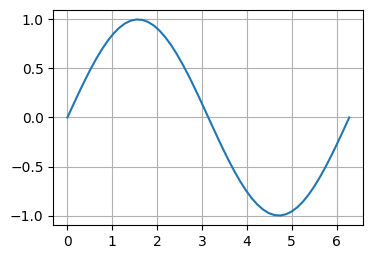

([<matplotlib.lines.Line2D at 0x1f35f3977a0>], None, None)

In [15]:
x = torch.linspace(0, 2*np.pi, steps=50, requires_grad=True)
y = torch.sin(x)
plt.figure(figsize=(4, 2.8))
plt.plot(x.detach(), y.detach()), plt.grid(), plt.show()

If you remove `detach()` it will give you the error as follows (We will explain further later.): 

`RuntimeError`: Can't call `numpy()` on Tensor that requires grad. Use `tensor.detach().numpy()` instead.

In [16]:
# Uncomment this statement to see the error.
# plt.plot(x, y)

Let’s have a closer look at the tensor `y`. When we print it, we see an indicator that it is tracking its computation history:

In [17]:
print(y)

tensor([ 0.0000e+00,  1.2788e-01,  2.5365e-01,  3.7527e-01,  4.9072e-01,
         5.9811e-01,  6.9568e-01,  7.8183e-01,  8.5514e-01,  9.1441e-01,
         9.5867e-01,  9.8718e-01,  9.9949e-01,  9.9538e-01,  9.7493e-01,
         9.3847e-01,  8.8660e-01,  8.2017e-01,  7.4028e-01,  6.4823e-01,
         5.4553e-01,  4.3388e-01,  3.1511e-01,  1.9116e-01,  6.4070e-02,
        -6.4070e-02, -1.9116e-01, -3.1511e-01, -4.3388e-01, -5.4553e-01,
        -6.4823e-01, -7.4028e-01, -8.2017e-01, -8.8660e-01, -9.3847e-01,
        -9.7493e-01, -9.9538e-01, -9.9949e-01, -9.8718e-01, -9.5867e-01,
        -9.1441e-01, -8.5514e-01, -7.8183e-01, -6.9568e-01, -5.9811e-01,
        -4.9072e-01, -3.7527e-01, -2.5365e-01, -1.2788e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


This `grad_fn` gives us a hint that when we execute the backpropagation step and compute gradients, we’ll need to compute the derivative of $\sin(\ldots)$ for all this tensor’s inputs.

To further undstand, let's perform some more computations

In [18]:
f = 2 * y
print(f)
g = f + 1
print(g)

tensor([ 0.0000e+00,  2.5575e-01,  5.0731e-01,  7.5053e-01,  9.8144e-01,
         1.1962e+00,  1.3914e+00,  1.5637e+00,  1.7103e+00,  1.8288e+00,
         1.9173e+00,  1.9744e+00,  1.9990e+00,  1.9908e+00,  1.9499e+00,
         1.8769e+00,  1.7732e+00,  1.6403e+00,  1.4806e+00,  1.2965e+00,
         1.0911e+00,  8.6777e-01,  6.3022e-01,  3.8232e-01,  1.2814e-01,
        -1.2814e-01, -3.8232e-01, -6.3022e-01, -8.6777e-01, -1.0911e+00,
        -1.2965e+00, -1.4806e+00, -1.6403e+00, -1.7732e+00, -1.8769e+00,
        -1.9499e+00, -1.9908e+00, -1.9990e+00, -1.9744e+00, -1.9173e+00,
        -1.8288e+00, -1.7103e+00, -1.5637e+00, -1.3914e+00, -1.1962e+00,
        -9.8144e-01, -7.5053e-01, -5.0731e-01, -2.5575e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000,  1.2558,  1.5073,  1.7505,  1.9814,  2.1962,  2.3914,  2.5637,
         2.7103,  2.8288,  2.9173,  2.9744,  2.9990,  2.9908,  2.9499,  2.8769,
         2.7732,  2.6403,  2.4806,  2.2965,  2.0911,  1.8678,  1.6302,  1.3823

Finally, let’s compute a single-element output. When you call `.backward()` on a tensor with no arguments, it expects the calling tensor to contain only a single element, as is the case when computing a loss function.

In [19]:
out = g.sum()
print(out)

tensor(50.0000, grad_fn=<SumBackward0>)


Each grad_fn stored with our tensors allows you to walk the computation all the way back to its inputs with its next_functions property. We can see below that drilling down on this property on d shows us the gradient functions for all the prior tensors. Note that `x.grad_fn` is reported as `None`, indicating that this was an input to the function with no history of its own. We will learn later, $x$ is the leaf node in a computational graph.

In [20]:
print("g:")
print(g.grad_fn)
print(g.grad_fn.next_functions)

g:
((<MulBackward0 object at 0x000001F35F3A7520>, 0), (None, 0))


To go further backward, we need to index into `b.grad_fn.next_functions`. In this case, it is a tuple of tuple.

In [21]:
print(g.grad_fn)
print(g.grad_fn.next_functions[0][0])
print(g.grad_fn.next_functions[0][0].next_functions[0][0])
print(g.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)

print('\nf:')
print(f.grad_fn)
print('\ny:')
print(y.grad_fn)
print('\nx:')
print(x.grad_fn)

((<AccumulateGrad object at 0x000001F3587623E0>, 0),)

f:

y:

x:
None


If you examine the output carefully enough, you will see that it all makes sense. Here is the explanation. Let us rewrite all the operations we have just defined

$$
y = \sin(x), \quad f = 2 y, \quad g = f + 1 \qquad\Rightarrow\qquad f = 2\sin(x), \quad g = 2 \sin(x) + 1
$$

The backward derivative for $g$ is *Addition Backward*, the backward derivative for $f$ is *Multiplication Backward*, and the backward derivative for $y$ is *Sine Backward*. The `AccumulatedGrad` object will appear clearer later. In short, if we call `backward()` several times, the gradient of the function with respect to the variable `x` will be accumulated over each `backward()` call.

With all this machinery in place, how do we get derivatives out? You call the `backward()` method on the output, and check the input’s grad property to inspect the gradients:

tensor([ 2.0000,  1.9836,  1.9346,  1.8538,  1.7426,  1.6028,  1.4367,  1.2470,
         1.0368,  0.8096,  0.5691,  0.3192,  0.0641, -0.1920, -0.4450, -0.6907,
        -0.9251, -1.1442, -1.3446, -1.5229, -1.6762, -1.8019, -1.8981, -1.9631,
        -1.9959, -1.9959, -1.9631, -1.8981, -1.8019, -1.6762, -1.5229, -1.3446,
        -1.1442, -0.9251, -0.6907, -0.4450, -0.1920,  0.0641,  0.3192,  0.5691,
         0.8096,  1.0368,  1.2470,  1.4367,  1.6028,  1.7426,  1.8538,  1.9346,
         1.9836,  2.0000])


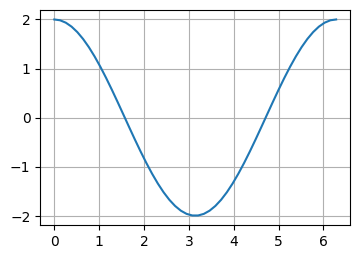

([<matplotlib.lines.Line2D at 0x1f35f797380>], None, None)

In [22]:
out.backward()
print(x.grad)
plt.figure(figsize=(4, 2.8))
plt.plot(x.detach(), x.grad.detach()), plt.grid(), plt.show()

# Don't re-execute the cell alone. It will give you error. Run everything above before. 
# Further explanation will be provided later.

Let us try to interpret this result. As mentioned above, $g(x) = f(y) + 1 = 2\times y + 1 = 2 \sin(x) + 1$. Therefore, the derivative of $g$ with respect to $x$ is $g^{\prime}(x) = 2 \cos(x)$. This is exactly what we see. Be aware that only leaf nodes of the computation have their gradients computed. If you tried, for example, `print(f.grad)` you’d get back `None`. In this simple example, only the input is a leaf node, so only it has gradients computed.

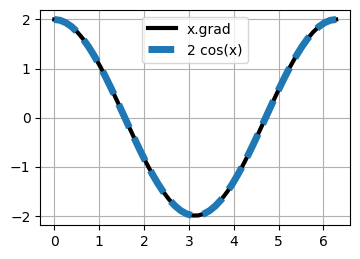

In [10]:
plt.figure(figsize=(4, 2.8))
plt.plot(x.detach(), x.grad.detach(), 'k-', linewidth=3, label='x.grad')
plt.plot(x.detach(), 2*torch.cos(x.detach()), '--', linewidth=5, label='2 cos(x)')
plt.grid(), plt.legend()
plt.show()

# A Less Simple Example.

Assume that we are given a function of three variables
$$f = \sin(x y) + \cos(y z) + \sin(x z) + x y + y z + x z$$
Then, the gradient of $f$ is given by
$$
\nabla f = \begin{bmatrix}
\displaystyle \frac{\partial f}{\partial x} \\[12pt]
\displaystyle \frac{\partial f}{\partial y} \\[12pt]
\displaystyle \frac{\partial f}{\partial z}
\end{bmatrix} = 
\begin{bmatrix}
y \cos(x y) + z \cos(x z) + y + z \\[12pt]
x \cos(x y) - z \sin(y z) + x + z \\[12pt]
x \cos(x z) - y \sin(y z) + x + y
\end{bmatrix}
$$

We will define $f$ as a function of three variables $x$, $y$, $z$ in PyTorch. However, you will soon see that it is not symbolic expression and not about symbolic calculation. Further explanation goes later.

## Symbolic calculation

Before learning automatic differention in PyTorch, let us take this opportunity to learn something new in Python. In fact, we can define a function perform various mathematical operations on it symbolically by using the Python library **SymPy**. As this notebook is not about learning SymPy, please refer to the [official website](https://www.sympy.org/en/index.html) and [official documentation](https://docs.sympy.org/latest/index.html) to learn more if you are interested in using the library in the future. For now, let us accept the following set of code without much explanation. Saying that, the code itself is pretty much self-explanatory.

In [11]:
x, y, z = sp.symbols("x, y, z")
f_sym = sp.sin(x*y) + sp.cos(y*z) + sp.sin(x*z) + x*y + y*z + x*z
df_dx = sp.diff(f_sym, x)
df_dy = sp.diff(f_sym, y)
df_dz = sp.diff(f_sym, z)
df = [df_dx, df_dy, df_dz]
print(df)

# If you run this code alone, you will see the printing format is very nice
sp.diff(f_sym, x)

[y*cos(x*y) + y + z*cos(x*z) + z, x*cos(x*y) + x - z*sin(y*z) + z, x*cos(x*z) + x - y*sin(y*z) + y]


y*cos(x*y) + y + z*cos(x*z) + z

**Substitution in symbolic calculation**

There are two ways to compute the function $f$ and $\nabla f$ at different points in $\mathbb{R}^{3}$.
- We can use the function `subs` to perform the subsitution of the symbolic variables by their corresponding numerical values.
- We can use the function `lambdify` to make create a Python function corresponding to the symbolic function. This Python function will accept the NumPy variable as input arguments.

In [12]:
a = [[(x, 1), (y, 1), (z, 1)], [(x, 1), (y, 2), (z, 3)]]
names = ['df_dx', 'df_dy', 'df_dz']
print(f"f(a1) = {f_sym.subs(a[0])}  -----  f(a2) = {f_sym.subs(a[1])}")
for i in range(len(df)):
    print(f"{names[i]}(a1) = {df[i].subs(a[0])}  -----  {names[i]}(a2) = {df[i].subs(a[1])}")

f(a1) = cos(1) + 2*sin(1) + 3  -----  f(a2) = sin(3) + sin(2) + cos(6) + 11
df_dx(a1) = 2*cos(1) + 2  -----  df_dx(a2) = 3*cos(3) + 2*cos(2) + 5
df_dy(a1) = -sin(1) + cos(1) + 2  -----  df_dy(a2) = cos(2) - 3*sin(6) + 4
df_dz(a1) = -sin(1) + cos(1) + 2  -----  df_dz(a2) = cos(3) - 2*sin(6) + 3


In [13]:
# If you want to compute numerical value, you must use the method evalf.
print(f"f(a1) = {f_sym.subs(a[0]).evalf()}  -----  f(a2) = {f_sym.subs(a[1]).evalf()}")
grad_f = []
for i in range(len(df)):
    grad_f.append([df[i].subs(a[0]).evalf(), df[i].subs(a[1]).evalf()])
    print(f"{names[i]}(a1) = {df[i].subs(a[0]).evalf()}  -----  {names[i]}(a2) = {df[i].subs(a[1]).evalf()}")

f(a1) = 5.22324427548393  -----  f(a2) = 13.0105877215359
df_dx(a1) = 3.08060461173628  -----  df_dx(a2) = 1.19772883710438
df_dy(a1) = 1.69883132106024  -----  df_dy(a2) = 4.42209965804964
df_dz(a1) = 1.69883132106024  -----  df_dz(a2) = 2.56883849979741


Now, we can try to use `lambdify` to create Python functions. You will see that the results will be indentical to the above ones.

In [14]:
f_np = sp.lambdify([x, y, z], f_sym)
x_np, y_np, z_np = np.array([1., 1.]), np.array([1., 2.]), np.array([1., 3.])

df_np = []
for i in range(len(df)):
    df_np.append(sp.lambdify([x, y, z], df[i]))

print(f"f(a) = {f_np(x_np, y_np, z_np)}")
for i in range(len(df)):
    print(f"{names[i]}(a) = {df_np[i](x_np, y_np, z_np)}")

f(a) = [ 5.22324428 13.01058772]
df_dx(a) = [3.08060461 1.19772884]
df_dy(a) = [1.69883132 4.42209966]
df_dz(a) = [1.69883132 2.5688385 ]


## Autograd in PyTorch

First of all, we must understand that **automatic differention** is not **symbolic differentiation**. Unlike symbolic calculation which is another mathematical branch of research, automatic differention aims at computing the derivatives of the function with its variables numerically and efficiently. Therefore, you will see that we have to define the function $f$ in terms of three tensors `x`, `y`, and `z` with specific values. Let us denote $\mathbf{a} = (x, y, z)$ and therefore $f = f(\mathbf{a})$. We normally want to compute $\nabla f$ at different points, not just at one point. This is doable in PyTorch by defining the tensors `x`, `y`, and `z` as arrays of multiple values. 

In this example, let us try to compute $f$ at two points $\mathbf{a}^{(1)} = (1, 1, 1)$ and $\mathbf{a}^{(2)} = (1, 2, 3)$ and also the gradient $\nabla f$ at theses two points. Thus, we need to compute $f(\mathbf{a}^{(1)})$, $f(\mathbf{a}^{(2)})$, and $\nabla f(\mathbf{a}^{(1)})$, $\nabla f(\mathbf{a}^{(2)})$. Before doing so in PyTorch, let us try to compute these quantities using symbolic calculation and subsitution as we have just learned above.

The above numerical values will be the reference values for our computation in PyTorch. Let us come back to the main point: Automatic differentian in PyTorch. We shall define three tensors `x`, `y`, `z` that take appropriate values to represent two points $\mathbf{a}^{(1)}$ and $\mathbf{a}^{(2)}$. Then, we will compute $f$ in terms of three tensors. **This computation is the forward propagation**. You see that we particularly set the keyword argument `requires_grade` to `True`. This is not necessary as by default `requires_grad=True`. However, it is good point this out for learning purppose.

In [15]:
x = torch.tensor([1., 1.], requires_grad=True)      
y = torch.tensor([1., 2.], requires_grad=True)
z = torch.tensor([1., 3.], requires_grad=True)
f = torch.sin(x*y) + torch.cos(y*z) + torch.sin(x*z) + x*y + y*z + x*z

Let's have a look at the tensor `f`. When we print it, we see an indicator that it is tracking its computation history.

In [16]:
print(f)    # The results perfectly match the symbolic calculation presented above.

tensor([ 5.2232, 13.0106], grad_fn=<AddBackward0>)


This `grad_fn` gives us a hint that when we execute the backpropagation step and compute gradients, we'll need to compute the derivative of the addition operation for all this tensor's inputs. It sounds very complex and abstract. Let us look at a smaller component of $f$, namely $f_1 = \sin(x y)$ to understand better.

In [17]:
f1 = torch.sin(x * y)
print(f1)

tensor([0.8415, 0.9093], grad_fn=<SinBackward0>)


So, the `grad_fn` just says that in order to compute the gradient of $f_1$, we need to compute the derivative of $\sin(\ldots)$ for all inputs of the tensor `f1`.

It is extremely easy to compute the gradient of $f$ in PyTorch. When we call `backward()` on the tensor `f`, autograd calculates these gradients and stores them in the respective tensors' `grad` attribute. However, as you have seen the tensor `f` is not just a number (a scalar) but a vector. We need to explicitly pass a `gradient` argument in `f.backward()`. The argument `gradient` is a tensor of the same shape as `f`, and it represents the gradient of $f$ with respect to itself, i.e.
$$
\frac{\mathrm{d} f}{\mathrm{d} f} = 1.
$$

In [18]:
f.backward(gradient=torch.tensor([1., 1.]))
print(x.grad, y.grad, z.grad)
print(np.array(grad_f))         # Again, as you can see, the results perfectly match the symbolic calculation presented above.

tensor([3.0806, 1.1977]) tensor([1.6988, 4.4221]) tensor([1.6988, 2.5688])
[[3.08060461173628 1.19772883710438]
 [1.69883132106024 4.42209965804964]
 [1.69883132106024 2.56883849979741]]


**Remark** &nbsp; Note that if you try to execute the above Python cell above one more time, you will see the error

`RuntimeError`: Trying to backward through the graph a second time (or directly access saved tensors after they have been freed)

The reason for this error is because we compute $f$, the computational graph will be constructed. However, when we call the method `backward()` on `f`, the computational graph will be got rid of. So, it or to call `backward()` again, we must recompute $f$. That is we need to execute the statement 
```python
f = torch.sin(x*y) + torch.cos(y*z) + torch.sin(x*z) + x*y + y*z + x*z
```

Therefore, the following block of code is fine to rerun again and again. For this reason, we should combine the step of computing `f` and the step of calling `backward()` on `f` in one code cell. The general rule would be one `backward()` call needs one forward propataion calculation.

In [19]:
f = torch.sin(x*y) + torch.cos(y*z) + torch.sin(x*z) + x*y + y*z + x*z
f.backward(gradient=torch.tensor([1., 1.]))
print(f"x.grad = {x.grad}")
print(f"y.grad = {y.grad}")
print(f"z.grad = {z.grad}" )

x.grad = tensor([6.1612, 2.3955])
y.grad = tensor([3.3977, 8.8442])
z.grad = tensor([3.3977, 5.1377])


At this point, if you examine the gradient of $f$ through `x.grad`, `y.grad` and `z.grad`, you should immediately see the results are wrong. Indeed, the presented values are double the correct values and if you re-run the above code cell again and again, the results will $3$x, $4$x bigger than the correct values. The reason is that the backward pass accumulate the computed values in the attribute `.grad`. So, if you call `backward()` two times, you have accumulated the gradients two times, and so on. In order to get the correct gradient in `x.grad`, `y.grad` and `z.grad` whenever we call `backward()` again, we must "zero out" the values stored in `grad` attrbitue. This is done by setting the `grad` attribute to `None`. So, the following code does this job.

In [20]:
x.grad.zero_(), y.grad.zero_(), z.grad.zero_()
# Or you can use the following statement. 
# x.grad, y.grad, z.grad = None, None, None
# This statement won't work: x.grad = 0  
# I prefer the x.grad.zero_() though because it carries a meaning.

f = torch.sin(x*y) + torch.cos(y*z) + torch.sin(x*z) + x*y + y*z + x*z

f.backward(gradient=torch.tensor([1., 1.]))
print(f"x.grad = {x.grad}")
print(f"y.grad = {y.grad}")
print(f"z.grad = {z.grad}" )

x.grad = tensor([3.0806, 1.1977])
y.grad = tensor([1.6988, 4.4221])
z.grad = tensor([1.6988, 2.5688])


### Aggregation and then backpropagation

Equivalently, we can also aggregate $f$ into a scalar and call backward implicitly, like `f.sum().backward()`.

In [21]:
x.grad, y.grad, z.grad = None, None, None
f = torch.sin(x*y) + torch.cos(y*z) + torch.sin(x*z) + x*y + y*z + x*z
f.sum().backward()

print(f"x.grad = {x.grad}")
print(f"y.grad = {y.grad}")
print(f"z.grad = {z.grad}" )
# Let us check whether our result is correct
coord_np = (x.detach().numpy(), y.detach().numpy(), z.detach().numpy())
df_val = [df_np[j](*coord_np) for j in range(len(df_np))]
print(f"df_dx = {df_val[0]}")
print(f"df_dy = {df_val[1]}")
print(f"df_dz = {df_val[2]}")

x.grad = tensor([3.0806, 1.1977])
y.grad = tensor([1.6988, 4.4221])
z.grad = tensor([1.6988, 2.5688])
df_dx = [3.0806046 1.197729 ]
df_dy = [1.6988313 4.4220996]
df_dz = [1.6988313 2.5688386]


The computation of the derivatives look qutie good. Let us compute the difference between them to see whether they are identical.

In [22]:
print(f"x.grad - df_dx = {x.grad.detach().numpy() - df_val[0]}")
print(f"y.grad - df_dy = {y.grad.detach().numpy() - df_val[1]}")
print(f"z.grad - df_dz = {z.grad.detach().numpy() - df_val[2]}")

x.grad - df_dx = [ 0.0000000e+00 -1.1920929e-07]
y.grad - df_dy = [0. 0.]
z.grad - df_dz = [ 0.0000000e+00 -2.3841858e-07]


As we can see, there is a small difference between the results of the backward operation and those using analytical formula. The backpropagation in the computational graph seems to accummulate errors through the backward stage. But $\ldots$

In [23]:
print(f"x_grad == df_dx: {np.allclose(x.grad.detach().numpy(), df_val[0])}")
print(f"y_grad == df_dy: {np.allclose(y.grad.detach().numpy(), df_val[1])}")
print(f"z_grad == df_dz: {np.allclose(z.grad.detach().numpy(), df_val[2])}")

x_grad == df_dx: True
y_grad == df_dy: True
z_grad == df_dz: True
